## Setting Up the Environment

### Imports and Dependencies

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from xml.dom.minidom import parse
from PIL import Image
from shutil import copyfile
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random
import cv2
!pip install seaborn
import seaborn as sns
import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Creating directory structure for the files to be used by the model

In [3]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

### Variables and identifiers to be used throughout the notebook

In [4]:
# TODO: make variables for the paths used throughout the notebook
class_labels = ['helmet','head','person']

### Helper function to scale the coordinates of the bounding box

In [5]:
def annotation_to_yolo(img_size , box_dim):
    x1 = int(box_dim[0])
    y1 = int(box_dim[1])
    x2 = int(box_dim[2])
    y2 = int(box_dim[3])
    
    scaledw = np.float32(1. / int(img_size[0]))
    scaledh = np.float32(1. / int(img_size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)
    
    x = x * scaledw
    y = y * scaledh
    w = w * scaledw
    h = h * scaledh
    
    return [x, y, w, h]

### Helper function to create text file when given input as [cls_label, x1, y1, x2, y2]

In [6]:
def save_to_txt(img_file_name, size, img_dim_box):
    save_file_name = '/kaggle/working/Dataset/labels/' +  img_file_name + '.txt'

    with open(save_file_name ,'a+') as path:
        for box in img_dim_box:

            cls_num = class_labels.index(box[0])

            yolo_input_box = annotation_to_yolo(size, box[1:])

            path.write(f"{cls_num} {yolo_input_box[0]} {yolo_input_box[1]} {yolo_input_box[2]} {yolo_input_box[3]}\n")

        path.flush()
        path.close()

### Function to take in input XML file and return .txt file with class label and coordinates of bounding boxes of identified objects in the images

In [7]:
def extract_xml_data(file_path, xml_filename):
    img_path = file_path + '/' + xml_filename + '.xml'
    domOBJ = parse(img_path)
    root = domOBJ.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    identified_objects_box = []
    
    # get the coordinates and classes for all identified objects for each image 
    # and save it in a text file to be fed as input to the model
    for obj in objects:
        cls_name = obj.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(obj.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(obj.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(obj.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(obj.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = xml_filename + '.jpg'
        identified_objects_box.append([cls_name, x1, y1, x2, y2])
  
    save_to_txt(xml_filename, [img_w, img_h], identified_objects_box)

In [ ]:
!ls /kaggle/working/Dataset/labels

### Go over each annotation file to create required labels in the form of text files for YOLO model

In [8]:
files = os.listdir('/kaggle/input/hard-hat-detection/annotations')
for file in files:
    file_xml = file.split(".")
    extract_xml_data('/kaggle/input/hard-hat-detection/annotations', file_xml[0])

### Create train-test split for training, testing and validation

In [9]:
from sklearn.model_selection import train_test_split
images = os.listdir('/kaggle/input/hard-hat-detection/images')
trainData, testData = train_test_split(images, test_size=0.2, random_state=1789)
valData, testData = train_test_split(testData, test_size=0.4, random_state=1789)
print('total =',len(images))
print('train :',len(trainData))
print('val   :',len(valData))
print('test  :',len(testData))

total = 5000
train : 4000
val   : 600
test  : 400


### Function to copy files and labels to sub-directories based on operation

In [10]:
def move_to_subdir(data_list, img_labels_root, imgs_source, operation):

    # for the case of the first image in that mode, the sub-directory will not exist and hence is created
    root_file = Path( '/kaggle/working/Dataset/images/'+  operation)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    # for the case of the first image in that mode, the sub-directory will not exist and hence is created
    root_file = Path('/kaggle/working/Dataset/labels/' + operation)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in data_list:               
        img_name = file.replace('.png', '')        
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'
        
        # resize image to 640 * 640
        image = Image.open(img_src_file)
#         new_image = image.resize((640, 640))

        # Copy image
        MODEL_IMG_DIR = '/kaggle/working/Dataset/images/'  + operation
        model_img_file = MODEL_IMG_DIR + '/' + img_name + '.png'
#         new_image.save(img_dict_file)

        copyfile(img_src_file, model_img_file)

        # Copy label
        MODEL_LABEL_DIR = '/kaggle/working/Dataset/labels/' + operation
        model_label_file = MODEL_LABEL_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, model_label_file)

### Create sub-directories for the training, testing and validation of the models

In [11]:
# creating subdirectories for required operations - train, test and validation
move_to_subdir(trainData, '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "train")
move_to_subdir(valData,   '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "val")
move_to_subdir(testData,  '/kaggle/working/Dataset/labels', '/kaggle/input/hard-hat-detection/images', "test")

Path /kaggle/working/Dataset/images/train does not exit
Path /kaggle/working/Dataset/labels/train does not exit
Path /kaggle/working/Dataset/images/val does not exit
Path /kaggle/working/Dataset/labels/val does not exit
Path /kaggle/working/Dataset/images/test does not exit
Path /kaggle/working/Dataset/labels/test does not exit


In [ ]:
!ls /kaggle/working/Dataset/images

## Dataset Visualization and Information

In [12]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.PngImagePlugin.PngImageFile'> 

Shape:  (416, 416, 3) 



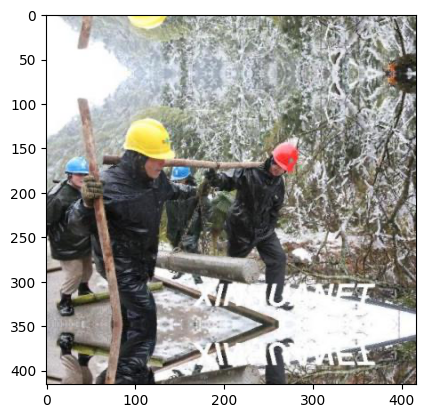

In [13]:
example_image_path = '/kaggle/input/hard-hat-detection/images/hard_hat_workers1012.png'
display_image(example_image_path, print_info = True, hide_axis = False)

In [14]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=1789):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

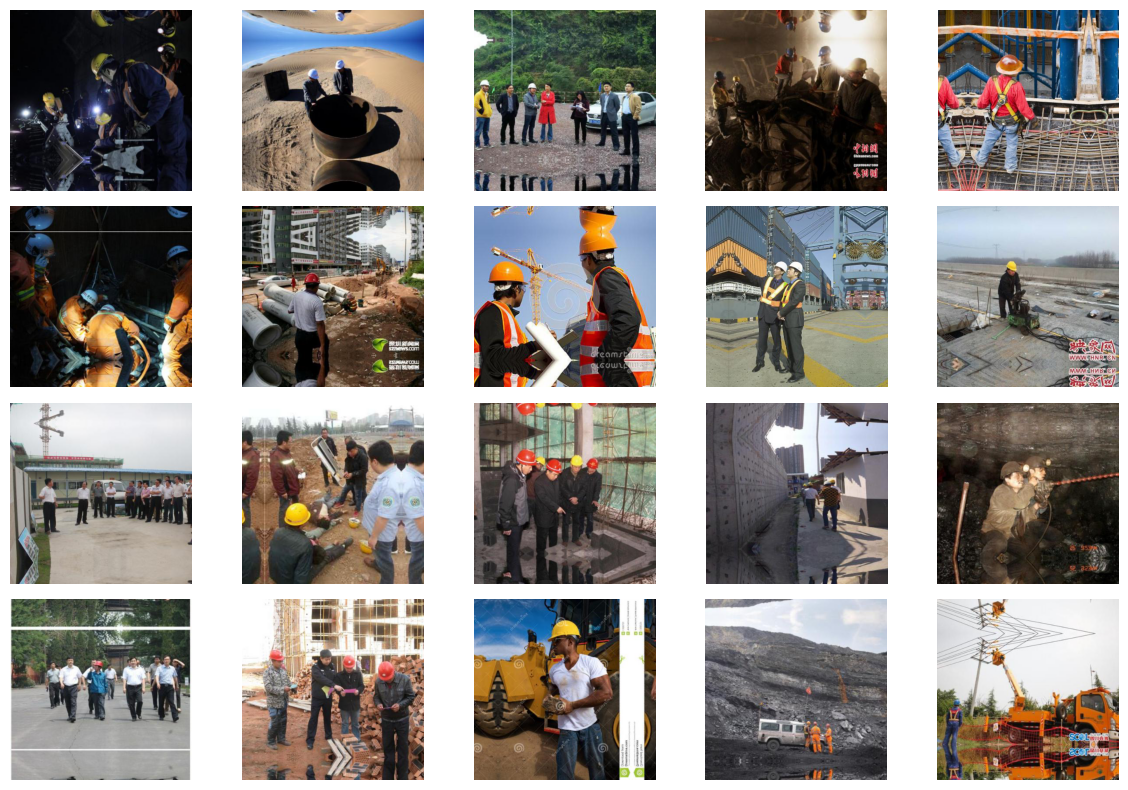

In [15]:
folder_path = '/kaggle/input/hard-hat-detection/images'
plot_random_images_from_folder(folder_path, num_images=20, seed=1789)

### Dataset Information

In [16]:
%%time
class_idx = {str(i): class_labels[i] for i in range(len(class_labels))}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'val', 'test']:
    class_count = {class_labels[i]: 0 for i in range(len(class_labels))}

    path = os.path.join('/kaggle/working/Dataset/labels', mode)

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 134 ms, sys: 64.7 ms, total: 199 ms
Wall time: 201 ms


,Mode,helmet,head,person,Data_Volume
0,train,3655,760,118,4000
1,val,551,101,29,600
2,test,375,59,11,400


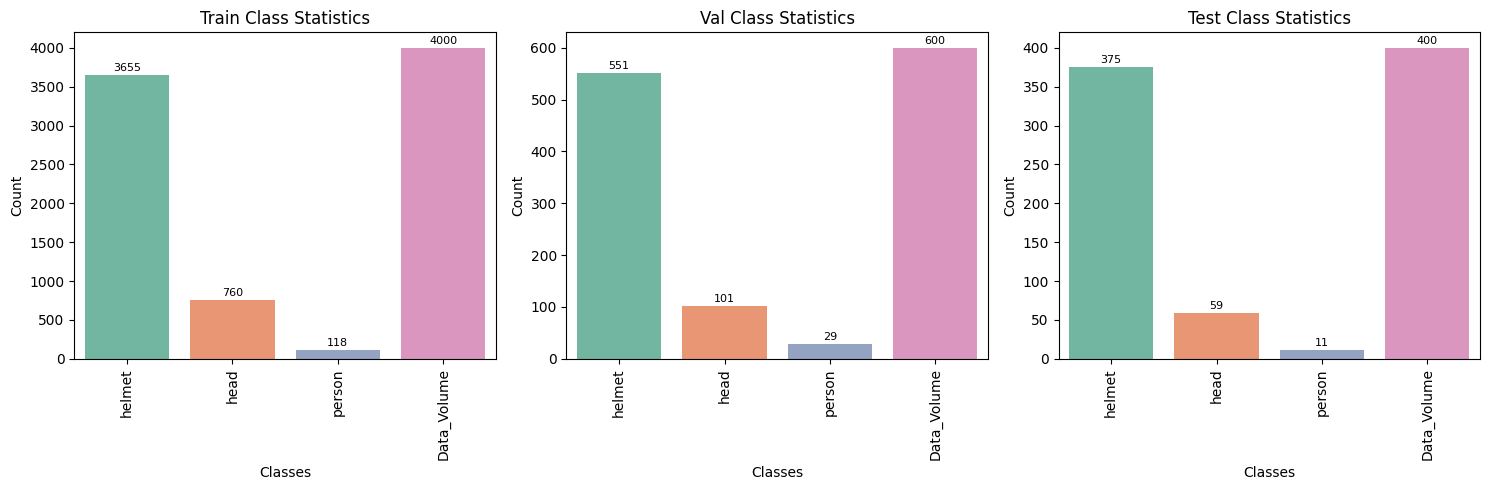

In [17]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'val', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

### Image Properties

In [18]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [19]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 416, 'height': 416, 'channels': 3, 'dtype': dtype('uint8')}

## Setting Up Model and training environment

### Set up Ultralytics package to use YOLO

In [20]:
# !git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.4/709.4 kB 13.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 20.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60


### Create config file to be used by the model to locate required files and class labels

In [21]:
import yaml

# Create configuration
config = {
   "path": "/kaggle/working/Dataset/images",
   "train": "train",
   "val": "val",
   "test": "test",
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [22]:
!cat data.yaml

names:
- helmet
- head
- person
nc: 3
path: /kaggle/working/Dataset/images
test: test
train: train
val: val


### Wandb is a tool to get insights during development stage, it is resource intensive and not required for the current use case

In [23]:
!wandb disabled

W&B disabled.


## Train model

In [24]:
!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=20 lr0=0.01

100%|███████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 244MB/s]
Ultralytics YOLOv8.1.8 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=20, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_

### List of generated results from previous run

In [25]:
!ls /kaggle/working/runs/detect/train

F1_curve.png					   train_batch1.jpg
PR_curve.png					   train_batch2.jpg
P_curve.png					   train_batch2500.jpg
R_curve.png					   train_batch2501.jpg
args.yaml					   train_batch2502.jpg
confusion_matrix.png				   val_batch0_labels.jpg
confusion_matrix_normalized.png			   val_batch0_pred.jpg
events.out.tfevents.1706780337.e8cd819960d7.131.0  val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
results.csv					   val_batch2_pred.jpg
results.png					   weights
train_batch0.jpg


### Validation Results

In [26]:
# validation data results
from ultralytics import YOLO
!yolo task=detect mode=val model="/kaggle/working/runs/detect/train/weights/best.pt" data=data.yaml

Ultralytics YOLOv8.1.8 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /kaggle/working/Dataset/labels/val.cache... 600 images, 0 backgrou
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        600       3065       0.95      0.599      0.646       0.43
                helmet        600       2242      0.953      0.889      0.956      0.637
                  head        600        680      0.897      0.907       0.95      0.638
                person        600        143          1          0     0.0326     0.0151
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Speed: 0.5ms preprocess, 5.0ms inference, 0.0ms loss, 1.0ms

## Visualization of results

In [27]:
results_paths = [
    i for i in
    glob.glob(f'/kaggle/working/runs/detect/train/*.png') +
    glob.glob(f'/kaggle/working/runs/detect/train/*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/train/confusion_matrix.png',
 '/kaggle/working/runs/detect/train/results.png',
 '/kaggle/working/runs/detect/train/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/train/PR_curve.png',
 '/kaggle/working/runs/detect/train/F1_curve.png',
 '/kaggle/working/runs/detect/train/P_curve.png',
 '/kaggle/working/runs/detect/train/R_curve.png',
 '/kaggle/working/runs/detect/train/labels_correlogram.jpg',
 '/kaggle/working/runs/detect/train/labels.jpg']

/kaggle/working/runs/detect/train/F1_curve.png


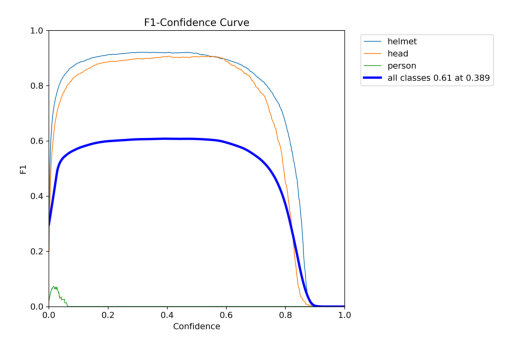



/kaggle/working/runs/detect/train/PR_curve.png


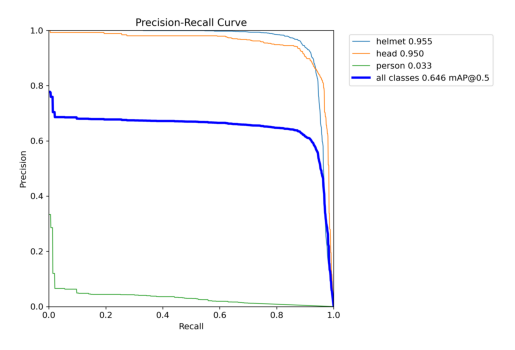



/kaggle/working/runs/detect/train/P_curve.png


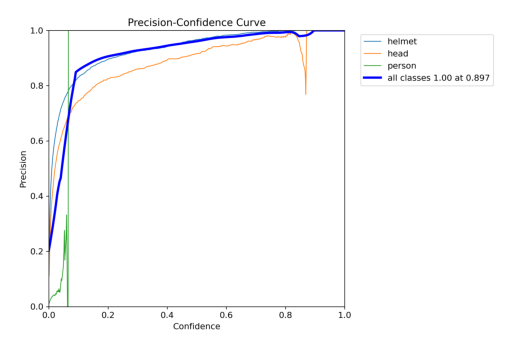



/kaggle/working/runs/detect/train/R_curve.png


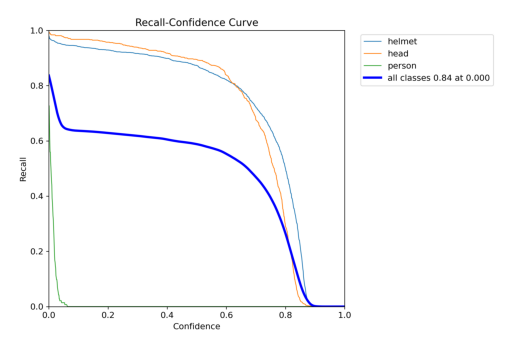



/kaggle/working/runs/detect/train/confusion_matrix.png


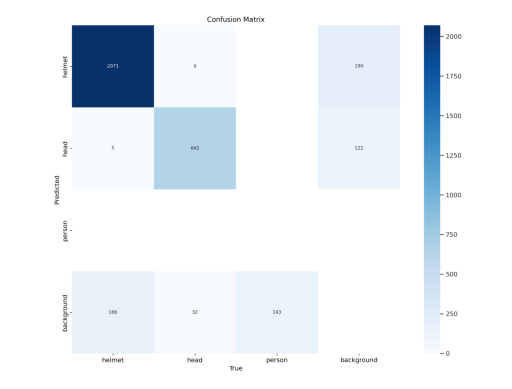



/kaggle/working/runs/detect/train/confusion_matrix_normalized.png


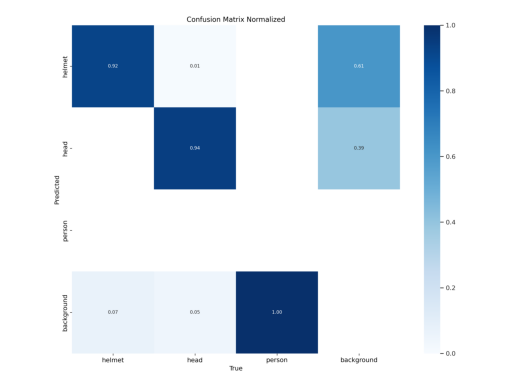



/kaggle/working/runs/detect/train/labels.jpg


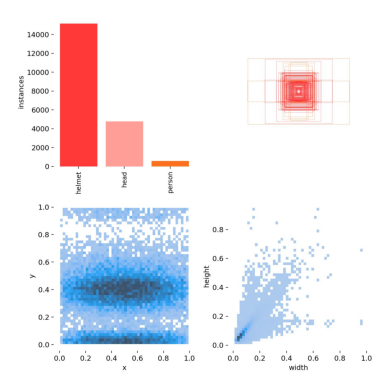



/kaggle/working/runs/detect/train/labels_correlogram.jpg


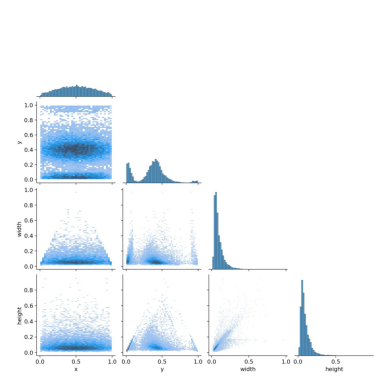



/kaggle/working/runs/detect/train/results.png


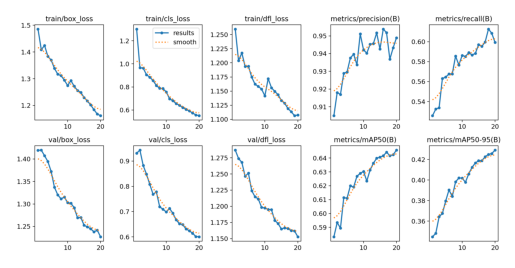

In [28]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [29]:
df = pd.read_csv(f'/kaggle/working/runs/detect/train/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'/kaggle/working/training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.4859,1.30200,1.2598,0.90496,0.52584,0.58324,0.34477,1.4194,0.93103,1.2869,0.000474,0.000474,0.000474
1,2,1.4088,0.96654,1.2037,0.91803,0.53255,0.59349,0.34818,1.4198,0.94321,1.2739,0.000904,0.000904,0.000904
2,3,1.4244,0.96284,1.2175,0.91696,0.53376,0.58946,0.36422,1.4072,0.88227,1.2679,0.001286,0.001286,0.001286
3,4,1.3836,0.90555,1.1936,0.92890,0.56308,0.61148,0.36747,1.3944,0.84775,1.2465,0.001217,0.001217,0.001217
4,5,1.3698,0.88469,1.1939,0.92958,0.56448,0.61101,0.37956,1.3722,0.80777,1.2512,0.001217,0.001217,0.001217
5,6,1.3386,0.85479,1.1747,0.93752,0.56771,0.62001,0.39035,1.3370,0.76849,1.2241,0.001146,0.001146,0.001146
6,7,1.3169,0.81199,1.1622,0.93966,0.56766,0.61903,0.38405,1.3203,0.77808,1.2148,0.001075,0.001075,0.001075
7,8,1.3115,0.78777,1.1583,0.93369,0.58563,0.62687,0.39815,1.3113,0.71933,1.2113,0.001005,0.001005,0.001005
8,9,1.2946,0.78613,1.1535,0.95111,0.57660,0.62892,0.40205,1.3153,0.70918,1.1984,0.000934,0.000934,0.000934
9,10,1.2747,0.75677,1.1415,0.94213,0.58625,0.63038,0.40191,1.3028,0.69869,1.1974,0.000863,0.000863,0.000863


In [30]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  1.1617 , on epoch:  20 


Best Validation Box loss:  1.227 , on epoch:  20 


Best Training Cls loss:  0.55074 , on epoch:  20 


Best Validation Cls loss:  0.60055 , on epoch:  20 


Best Training DFL loss:  1.1065 , on epoch:  20 


Best Validation DFL loss:  1.1529 , on epoch:  20 



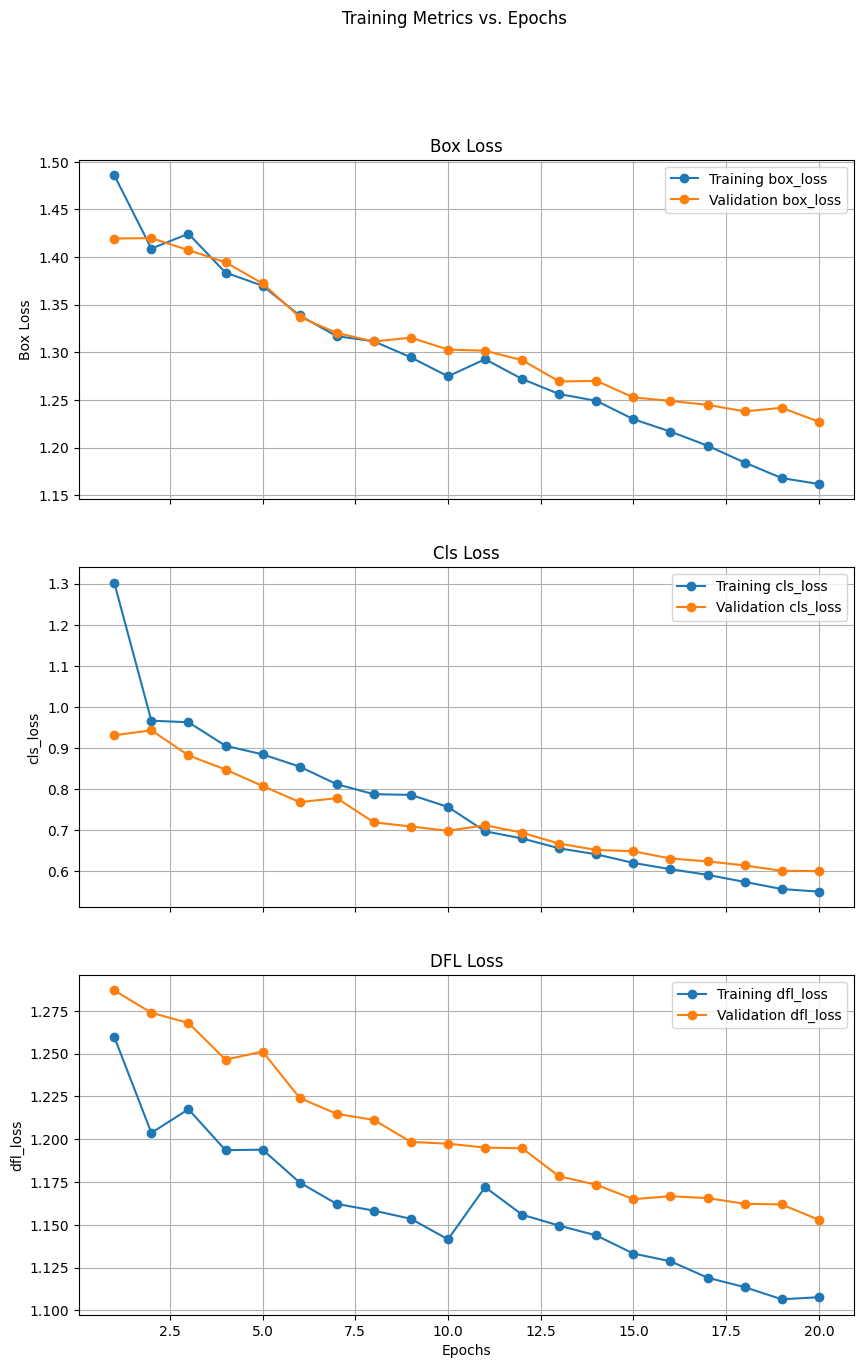

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation Box Loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

## Experimentation Results

### Attempt to load pre-trained weights of base (CSPNet) model to GhostNet model

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8-ghost.yaml').load('yolov8s.pt')

### CSPNet Backbone - 20 Epochs

In [ ]:
!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=20 lr0=0.01

    Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        500       2422      0.956      0.578      0.634      0.415
                helmet        500       1922       0.95      0.898      0.956      0.624
                  head        500        396      0.918      0.836       0.91      0.605
                person        500        104          1          0     0.0341      0.016

### GhostNet Backbone - 30 Epochs

In [ ]:
!yolo task=detect mode=train data=data.yaml model='/kaggle/input/ultralytics-repo-clone/ultralytics/ultralytics/cfg/models/v8/yolov8-ghost.yaml' epochs=30 lr0=0.01

    YOLOv8-ghost summary (fused): 312 layers, 1714661 parameters, 0 gradients, 5.0 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        500       2422      0.907      0.501      0.561      0.343
                helmet        500       1922      0.914      0.789       0.88      0.547
                  head        500        396      0.806      0.715      0.787      0.478
                person        500        104          1          0     0.0158    0.00479

### GhostNet Backbone with fixed size images (640 * 640) - 20 Epochs

In [ ]:
!yolo task=detect mode=train data=data.yaml model='/kaggle/input/ultralytics-repo-clone/ultralytics/ultralytics/cfg/models/v8/yolov8-ghost.yaml' epochs=20 lr0=0.01 imgsz=640

    YOLOv8-ghost summary (fused): 312 layers, 1714661 parameters, 0 gradients, 5.0 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        500       2422       0.89      0.465      0.533      0.323
                helmet        500       1922      0.863      0.758      0.845      0.515
                  head        500        396      0.806      0.639      0.741       0.45
                person        500        104          1          0     0.0134    0.00431

### CSPNet Backbone with fixed size images (640 * 640) - 20 epochs, LR 0.001

In [ ]:
!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=20 lr0=0.001

    Ultralytics YOLOv8.1.8 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla T4, 15102MiB)
        Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        600       3065      0.958      0.595      0.644      0.427
                helmet        600       2242      0.965      0.881      0.958      0.634
                  head        600        680       0.91      0.904       0.95      0.636
                person        600        143          1          0     0.0241     0.0104
        Speed: 0.6ms preprocess, 4.7ms inference, 0.0ms loss, 1.3ms postprocess per image